# Mie Scattering of a Lossless Dielectric Sphere

A common reference calculation in computational electromagnetics for which an analytical solution is known is [Mie scattering](https://en.wikipedia.org/wiki/Mie_scattering) which involves computing the [scattering efficiency](http://www.thermopedia.com/content/956/) of a single, homogeneous sphere given an incident planewave. The scattered power of any object (absorbing or non) can be computed by surrounding it with a *closed* [DFT flux](https://meep.readthedocs.io/en/latest/Python_User_Interface/#flux-spectra) box (its size and orientation are irrelevant because of Poynting's theorem) and performing two simulations: (1) a normalization run involving an empty cell to save the incident fields from the source and (2) the scattering run with the object but first subtracting the incident fields in order to obtain just the scattered fields. This approach has already been described in [Transmittance Spectrum of a Waveguide Bend](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics#transmittance-spectrum-of-a-waveguide-bend).

The scattering cross section is the scattered power in all directions divided by the incident intensity. The scattering efficiency, a dimensionless quantity, is the ratio of the scattering cross section to the cross sectional area of the sphere. In this demonstration, the sphere is a lossless dielectric with wavelength-independent refractive index of 2.0. This way, [subpixel smoothing](https://meep.readthedocs.io/en/latest/Subpixel_Smoothing) can improve accuracy at low resolutions which is important for reducing the size of this 3d simulation. The source is an $E_z$-polarized, planewave pulse (its `size` parameter fills the *entire* cell in 2d) spanning the broadband wavelength spectrum of 10% to 50% the circumference of the sphere. There is one subtlety: since the [planewave source extends into the PML](https://meep.readthedocs.io/en/latest/Perfectly_Matched_Layer/#planewave-sources-extending-into-pml) which surrounds the cell on all sides, `is_integrated=True` must be specified in the source object definition. A `k_point` of zero specifying periodic boundary conditions is necessary in order for the source to be infinitely extended. Also, given the [symmetry of the fields and the structure](https://meep.readthedocs.io/en/latest/Exploiting_Symmetry), two mirror symmery planes can be used to reduce the cell size by a factor of four. The simulation results are validated by comparing with the analytic theory obtained from the [PyMieScatt](https://pymiescatt.readthedocs.io/en/latest/) module (which you will have to install in order to run the script below).

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import PyMieScatt as ps
import json
import os
import matplotlib.pyplot as plt

keyword = "Normal"
path = "SurfaceData/surfaceParams" + keyword + ".json"
def load_params(path = path):
    with open(path, "r") as f:
        return json.load(f)
params = load_params()

# Cell and resolution
#pml_thickness = params["pml_thickness"]
#half_x = params["halfWidth_x"]
#half_y = params["halfWidth_y"]
#half_z = params["halfWidth_z"]
#cell_size = mp.Vector3(half_x + 2*pml_thickness,
#                       half_y + 2*pml_thickness,
#                       half_z + 2*pml_thickness)
#resolution = params["resolution"]


# Material
epsilon1 = params["epsilon1"] 
substrate = mp.Medium(epsilon = epsilon1)
#bumps = params["bumpData"]
bumps = []

r = 1.0  # radius of sphere

wvl_min = 2 * np.pi * r / 10
wvl_max = 2 * np.pi * r / 2

frq_min = 1 / wvl_max
frq_max = 1 / wvl_min
frq_cen = 0.5 * (frq_min + frq_max)
dfrq = frq_max - frq_min
nfrq = 1

## at least 8 pixels per smallest wavelength, i.e. np.floor(8/wvl_min)
resolution = 10

dpml = 0.5 * wvl_max
dair = 0.5 * wvl_max

pml_layers = [mp.PML(thickness=dpml)] 

s = 2 * (dpml + dair + r)
cell_size = mp.Vector3(s, s, s)

betas = params["betas"]

def make_source(component):
    return [mp.Source(
        mp.GaussianSource(frequency=frq_cen, fwidth=dfrq, is_integrated=True),
        center=mp.Vector3(0, 0, 0.5 * s + dpml),
        size=mp.Vector3(s, s, 0),
        component=component
    )]

def run_meep_simulation(sources):
    # Reference simulation (no bumps)
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
    )

    box_x1 = sim.add_flux(frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(x=-r), size=mp.Vector3(0, 2*r, 2*r)))
    box_x2 = sim.add_flux(frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(x=+r), size=mp.Vector3(0, 2*r, 2*r)))
    box_y1 = sim.add_flux(frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(y=-r), size=mp.Vector3(2*r, 0, 2*r)))
    box_y2 = sim.add_flux(frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(y=+r), size=mp.Vector3(2*r, 0, 2*r)))
    box_z1 = sim.add_flux(frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(z=-r), size=mp.Vector3(2*r, 2*r, 0)))
    box_z2 = sim.add_flux(frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(z=+r), size=mp.Vector3(2*r, 2*r, 0)))

    sim.run(until_after_sources=10)

    freqs = mp.get_flux_freqs(box_x1)
    box_x1_data = sim.get_flux_data(box_x1)
    box_x2_data = sim.get_flux_data(box_x2)
    box_y1_data = sim.get_flux_data(box_y1)
    box_y2_data = sim.get_flux_data(box_y2)
    box_z1_data = sim.get_flux_data(box_z1)
    box_z2_data = sim.get_flux_data(box_z2)

    box_x1_flux0 = mp.get_fluxes(box_x1)
    sim.reset_meep()

    # Structured simulation (with bumps)
    def material_function(p):
        z_surface = sum(
            b["height"] * np.exp(-((p.x - b["x0"])**2 + (p.y - b["y0"])**2) / (2 * b["sigma"]**2))
            for b in bumps
        )
        return substrate if p.z < z_surface else mp.air

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
        default_material=material_function,
    )

    box_x1 = sim.add_flux(frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(x=-r), size=mp.Vector3(0, 2*r, 2*r)))
    box_x2 = sim.add_flux(frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(x=+r), size=mp.Vector3(0, 2*r, 2*r)))
    box_y1 = sim.add_flux(frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(y=-r), size=mp.Vector3(2*r, 0, 2*r)))
    box_y2 = sim.add_flux(frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(y=+r), size=mp.Vector3(2*r, 0, 2*r)))
    box_z1 = sim.add_flux(frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(z=-r), size=mp.Vector3(2*r, 2*r, 0)))
    box_z2 = sim.add_flux(frq_cen, dfrq, nfrq, mp.FluxRegion(center=mp.Vector3(z=+r), size=mp.Vector3(2*r, 2*r, 0)))

    sim.load_minus_flux_data(box_x1, box_x1_data)
    sim.load_minus_flux_data(box_x2, box_x2_data)
    sim.load_minus_flux_data(box_y1, box_y1_data)
    sim.load_minus_flux_data(box_y2, box_y2_data)
    sim.load_minus_flux_data(box_z1, box_z1_data)
    sim.load_minus_flux_data(box_z2, box_z2_data)

    sim.run(until_after_sources=100)

    box_x1_flux = mp.get_fluxes(box_x1)
    box_x2_flux = mp.get_fluxes(box_x2)
    box_y1_flux = mp.get_fluxes(box_y1)
    box_y2_flux = mp.get_fluxes(box_y2)
    box_z1_flux = mp.get_fluxes(box_z1)
    box_z2_flux = mp.get_fluxes(box_z2)

    scatt_flux = (
        np.asarray(box_x1_flux)
        - np.asarray(box_x2_flux)
        + np.asarray(box_y1_flux)
        - np.asarray(box_y2_flux)
        + np.asarray(box_z1_flux)
        - np.asarray(box_z2_flux)
    )
    intensity = np.asarray(box_x1_flux0) / (2 * r)**2
    scatt_cross_section = np.divide(scatt_flux, intensity)
    scatt_eff = scatt_cross_section * -1 / (np.pi * r**2)

    # Save individual components for later printing/plotting
    scatt_flux_components = {
        "X1": np.asarray(box_x1_flux)[0],
        "X2": np.asarray(box_x2_flux)[0],
        "Y1": np.asarray(box_y1_flux)[0],
        "Y2": np.asarray(box_y2_flux)[0],
        "Z1": np.asarray(box_z1_flux)[0],
        "Z2": np.asarray(box_z2_flux)[0],
        "scatt_total": scatt_flux[0],
    }


    return scatt_eff, scatt_flux_components

scatt_eff_list = []
flux_results = []

for beta in zip(betas):
    print("beta = " + str(beta))
    cos2 = np.cos(beta)**2
    sin2 = np.sin(beta)**2

    sources_ex = make_source(mp.Ex)
    sources_ey = make_source(mp.Ey)

    Qx, flux_ex = run_meep_simulation(sources_ex)
    Qy, flux_ey = run_meep_simulation(sources_ey)

    Q_beta = cos2 * Qx + sin2 * Qy
    scatt_eff_list.append(Q_beta)

    # Combine flux components manually
    flux_combined = {
        "beta": np.degrees(beta),
        "X1": cos2 * flux_ex["X1"] + sin2 * flux_ey["X1"],
        "X2": cos2 * flux_ex["X2"] + sin2 * flux_ey["X2"],
        "Y1": cos2 * flux_ex["Y1"] + sin2 * flux_ey["Y1"],
        "Y2": cos2 * flux_ex["Y2"] + sin2 * flux_ey["Y2"],
        "Z1": cos2 * flux_ex["Z1"] + sin2 * flux_ey["Z1"],
        "Z2": cos2 * flux_ex["Z2"] + sin2 * flux_ey["Z2"],
        "scatt_total": cos2 * flux_ex["scatt_total"] + sin2 * flux_ey["scatt_total"]
    }

    flux_results.append(flux_combined)




beta = (0.0,)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00143409 s
Working in 3D dimensions.
Computational cell is 8.3 x 8.3 x 8.3 with resolution 10
time for set_epsilon = 1.25334 s
-----------
Meep progress: 0.8500000000000001/17.853981494903564 = 4.8% done in 4.0s, 80.4s to go
on time step 17 (time=0.85), 0.236325 s/step
Meep progress: 6.65/17.853981494903564 = 37.2% done in 8.0s, 13.6s to go
on time step 133 (time=6.65), 0.034695 s/step
Meep progress: 12.350000000000001/17.853981494903564 = 69.2% done in 12.1s, 5.4s to go
on time step 247 (time=12.35), 0.0352237 s/step


run 0 finished at t = 17.900000000000002 (358 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000753164 s
Working in 3D dimensions.
Computational cell is 8.3 x 8.3 x 8.3 with resolution 10
time for set_epsilon = 12.5051 s
-----------
Meep progress: 3.25/107.85398149490356 = 3.0% done in 4.0s, 129.2s to go
on time step 65 (time=3.25), 0.0617462 s/step
Meep progress: 10.450000000000001/107.85398149490356 = 9.7% done in 8.0s, 74.8s to go
on time step 209 (time=10.45), 0.0278212 s/step
Meep progress: 18.0/107.85398149490356 = 16.7% done in 12.0s, 60.1s to go
on time step 360 (time=18), 0.0265947 s/step
Meep progress: 25.150000000000002/107.85398149490356 = 23.3% done in 16.1s, 52.8s to go
on time step 503 (time=25.15), 0.0281255 s/step
Meep progress: 31.75/107.85398149490356 = 29.4% done in 20.1s, 48.1s to go
on time step 635 (time=31.75), 0.0303663 s/step
Meep progress: 41.900000000000006/107.85398149490356 = 38.8% done in 24.1s, 37.9s to go
on time step

run 0 finished at t = 107.9 (2158 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000334978 s
Working in 3D dimensions.
Computational cell is 8.3 x 8.3 x 8.3 with resolution 10
time for set_epsilon = 1.00535 s
-----------
Meep progress: 3.5/17.853981494903564 = 19.6% done in 4.0s, 16.5s to go
on time step 70 (time=3.5), 0.0573545 s/step
Meep progress: 10.4/17.853981494903564 = 58.3% done in 8.0s, 5.8s to go
on time step 208 (time=10.4), 0.0290528 s/step
Meep progress: 17.650000000000002/17.853981494903564 = 98.9% done in 12.0s, 0.1s to go
on time step 354 (time=17.7), 0.0275505 s/step


run 0 finished at t = 17.900000000000002 (358 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000497818 s
Working in 3D dimensions.
Computational cell is 8.3 x 8.3 x 8.3 with resolution 10
time for set_epsilon = 12.548 s
-----------
Meep progress: 2.9000000000000004/107.85398149490356 = 2.7% done in 4.0s, 145.0s to go
on time step 58 (time=2.9), 0.0690868 s/step
Meep progress: 10.25/107.85398149490356 = 9.5% done in 8.0s, 76.3s to go
on time step 205 (time=10.25), 0.027233 s/step
Meep progress: 18.0/107.85398149490356 = 16.7% done in 12.0s, 60.0s to go
on time step 360 (time=18), 0.0258074 s/step
Meep progress: 25.450000000000003/107.85398149490356 = 23.6% done in 16.0s, 51.9s to go
on time step 509 (time=25.45), 0.0269875 s/step
Meep progress: 32.0/107.85398149490356 = 29.7% done in 20.0s, 47.5s to go
on time step 640 (time=32), 0.0305833 s/step
Meep progress: 37.300000000000004/107.85398149490356 = 34.6% done in 24.1s, 45.5s to go
on time step 746 (

KeyboardInterrupt: 

In [ ]:
def scalar(val):
    return val.item() if isinstance(val, np.ndarray) else val

for entry in flux_results:
    print(f"\n--- β = {scalar(entry['beta']):.1f}° ---")
    print(f"X1 (−x): {scalar(entry['X1']):.5f}")
    print(f"X2 (+x): {scalar(entry['X2']):.5f}")
    print(f"Y1 (−y): {scalar(entry['Y1']):.5f}")
    print(f"Y2 (+y): {scalar(entry['Y2']):.5f}")
    print(f"Z1 (−z): {scalar(entry['Z1']):.5f}")
    print(f"Z2 (+z): {scalar(entry['Z2']):.5f}")
    print(f"Scattered Total: {scalar(entry['scatt_total']):.5f}")



--- β = 0.0° ---
X1 (−x): 0.01045
X2 (+x): -0.00175
Y1 (−y): 0.00339
Y2 (+y): -0.00676
Z1 (−z): -0.01117
Z2 (+z): 0.33138
Scattered Total: -0.32021

--- β = 22.5° ---
X1 (−x): 0.01025
X2 (+x): -0.00163
Y1 (−y): 0.00349
Y2 (+y): -0.00688
Z1 (−z): -0.01117
Z2 (+z): 0.33120
Scattered Total: -0.32012

--- β = 45.0° ---
X1 (−x): 0.00979
X2 (+x): -0.00133
Y1 (−y): 0.00373
Y2 (+y): -0.00718
Z1 (−z): -0.01117
Z2 (+z): 0.33077
Scattered Total: -0.31991

--- β = 67.5° ---
X1 (−x): 0.00932
X2 (+x): -0.00103
Y1 (−y): 0.00398
Y2 (+y): -0.00747
Z1 (−z): -0.01117
Z2 (+z): 0.33033
Scattered Total: -0.31971

--- β = 90.0° ---
X1 (−x): 0.00912
X2 (+x): -0.00091
Y1 (−y): 0.00408
Y2 (+y): -0.00760
Z1 (−z): -0.01117
Z2 (+z): 0.33016
Scattered Total: -0.31962


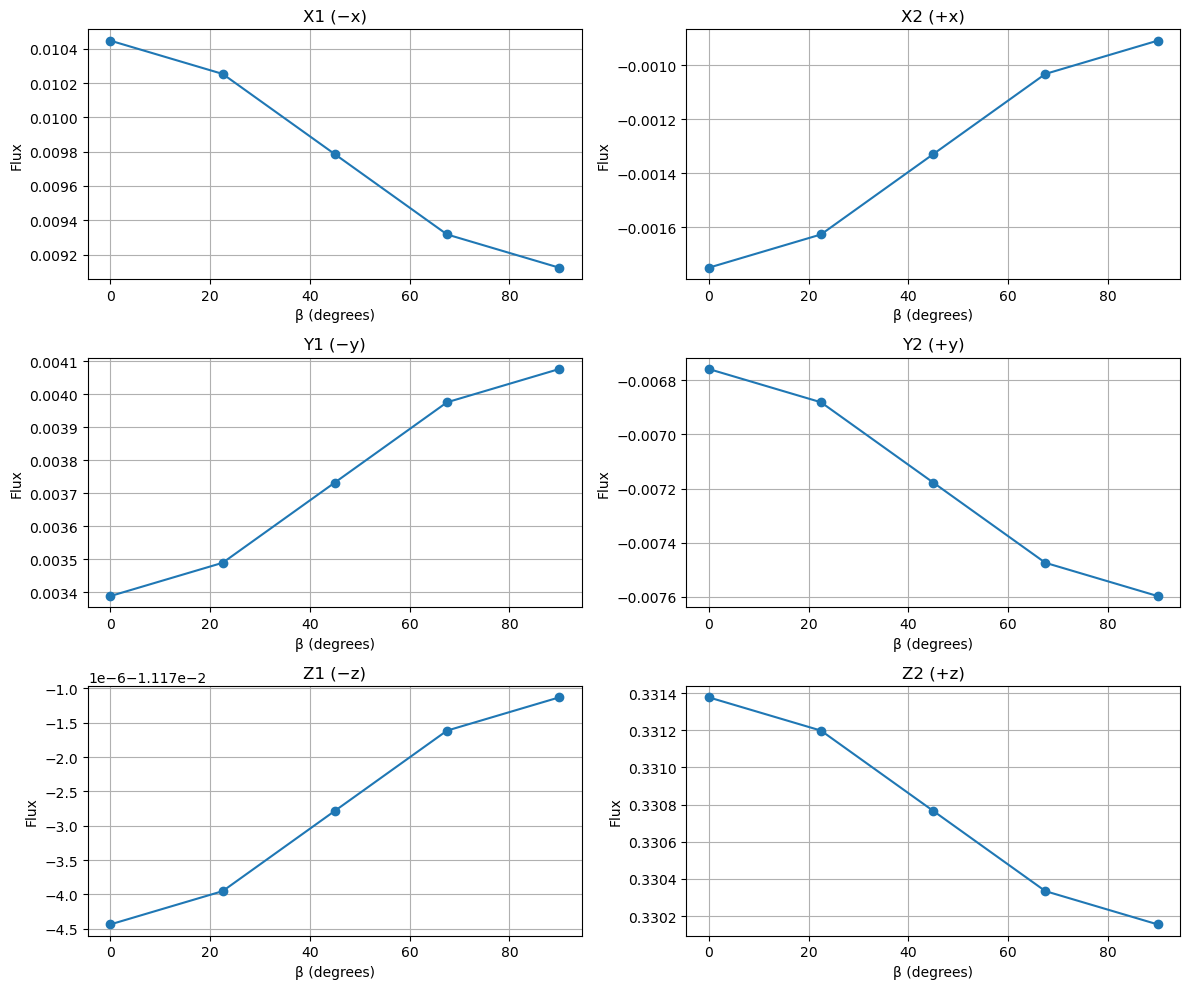

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to scalar values if needed
def scalar(val):
    return val.item() if isinstance(val, np.ndarray) else val

# Extract data
betas = [scalar(entry['beta']) for entry in flux_results]
X1 = [scalar(entry['X1']) for entry in flux_results]
X2 = [scalar(entry['X2']) for entry in flux_results]
Y1 = [scalar(entry['Y1']) for entry in flux_results]
Y2 = [scalar(entry['Y2']) for entry in flux_results]
Z1 = [scalar(entry['Z1']) for entry in flux_results]
Z2 = [scalar(entry['Z2']) for entry in flux_results]

# Set up subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

# Plot each component
labels = ['X1 (−x)', 'X2 (+x)', 'Y1 (−y)', 'Y2 (+y)', 'Z1 (−z)', 'Z2 (+z)']
values = [X1, X2, Y1, Y2, Z1, Z2]

for i, (label, val) in enumerate(zip(labels, values)):
    axs[i].plot(betas, val, marker='o')
    axs[i].set_title(label)
    axs[i].set_xlabel("β (degrees)")
    axs[i].set_ylabel("Flux")
    axs[i].grid(True)

# Hide unused subplot if any
if len(axs) > len(labels):
    axs[-1].axis('off')

plt.tight_layout()
plt.show()


The incident intensity (`intensity`) is the flux in one of the six monitor planes (the one closest to and facing the planewave source propagating in the $x$ direction) divided by its area. This is why the six sides of the flux box are defined separately. (Otherwise, the entire box could have been defined as a single flux object with different weights ±1 for each side.) The scattered power is multiplied by -1 since it is the *outgoing* power (a positive quantity) rather than the incoming power as defined by the orientation of the flux box. Note that because of the linear $E_z$ polarization of the source, the flux through the $y$ and $z$ planes will *not* be the same. A circularly-polarized source would have produced equal flux in these two monitor planes. The runtime of the scattering run is chosen to be sufficiently long to ensure that the Fourier-transformed fields have [converged](https://meep.readthedocs.io/en/latest/FAQ/checking-convergence).

Results are shown below. Overall, the Meep results agree well with the analytic theory.

In [ ]:
plt.figure(dpi=150)
plt.loglog(2 * np.pi * r * np.asarray(freqs), scatt_eff_meep, "bo-", label="Meep")
plt.loglog(2 * np.pi * r * np.asarray(freqs), scatt_eff_theory, "ro-", label="theory")
plt.grid(True, which="both", ls="-")
plt.xlabel("(sphere circumference)/wavelength, 2πr/λ")
plt.ylabel("scattering efficiency, σ/πr$^{2}$")
plt.legend(loc="upper right")
plt.title("Mie Scattering of a Lossless Dielectric Sphere")
plt.tight_layout()
plt.show()

![](https://meep.readthedocs.io/en/latest/images/mie_scattering.png)

Finally, for the case of a *lossy* dielectric material (i.e. complex refractive index) with non-zero absorption, the procedure to obtain the scattering efficiency is the same. The absorption efficiency is the ratio of the absorption cross section to the cross sectional area of the sphere. The absorption cross section is the total absorbed power divided by the incident intensity. The absorbed power is simply flux into the same box as for the scattered power, but *without* subtracting the incident field (and with the opposite sign, since absorption is flux *into* the box and scattering is flux *out of* the box): omit the `load_minus_flux_data` calls.